This notebook is a test zone for the new high-level API I made for frequency tracking in the package. 

In [1]:
import datetime as dt
import numpy as np
import scipy.signal as signal 
import matplotlib.pyplot as plt 
import soundfile as sf
from measure_horseshoe_bat_calls.frequency_tracking import *
from measure_horseshoe_bat_calls.data import example_calls
from measure_horseshoe_bat_calls.view_horseshoebat_call import *

In [2]:
%matplotlib notebook

In [3]:
eg_data = example_calls[19]
audio, fs = eg_data[0], eg_data[1]
# shorten the audio a bit
onems = int(0.001*fs)
#audio = audio[int(2.5*onems):-int(4.5*onems)]

b,a = signal.butter(1, np.array([15000, 115000])/(fs*0.5), 'bandpass')
hp_filter = signal.butter(1, 22000/(0.5*fs), 'highpass')
bp_audio = signal.filtfilt(b,a, audio)
hp_audio = signal.filtfilt(hp_filter[0], hp_filter[1], bp_audio)

In [4]:
w, s = visualise_call(hp_audio, fs, fft_size=128)
#s.set_ylim(0,80*10**3)
window_type = signal.hanning(onems)

<IPython.core.display.Javascript object>

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
raw, noise_sup, clean = get_frequency_profile_through_pwvd(hp_audio, fs, background_noise=-50, window=window_type,
                                                          percentile=99.5)
s.plot(make_x_time(clean,fs),clean)

In [6]:
plt.figure()
a = plt.subplot(211)
plt.plot(clean)
plt.subplot(212, sharex=a)
plt.plot(abs(np.gradient(clean)))

<IPython.core.display.Javascript object>

In [7]:
import scipy.ndimage as ndimage

In [8]:
def smooth_over_potholes(X, fs, **kwargs):
    '''
    A signal can show drastic changes in its value because of measurement errors.
    These drastic variations in signal can cause the creation of [potholes](https://en.wikipedia.org/wiki/Pothole)
    (holes in a road). This method tries to 'level' out the pothole by re-setting the samples of the 
    pothole. A linear interpolation is done from the start of a pothole till its end using the closest 
    non-pothole samples. 
    
    A pothole is identified by a region of the signal with drastic changes in slope. A moving window
    calculates the slopes between the focal sample and the Nth sample after it to estimate if 
    the values move gradually or not. 

    Parameters
    ----------
    X : np.array
    fs : float>0
    max_stepsize : float>0, optional 
        The maximum absolute difference between adjacent samples. 
        Defaults to 50. 
    pothole_inspection_window : float>0, optional
        The length of the moving window that's used to discover potholes.

    Returns
    -------
    pothole_covered
    pothol
    
    
    -=
    See Also
    --------
    identify_pothole_samples
    find_non_forbidden_index
    
    '''
    potholes, _ = identify_pothole_samples(X, fs,**kwargs)

    abnormal_fm, num_regions = ndimage.label(potholes>0)
    if num_regions < 1:
        return X, []
    else:
        pothole_covered = X.copy()
        pothole_regions = ndimage.find_objects(abnormal_fm)
        spikeish_indices = get_all_spikeish_indices(pothole_regions)
        for each_region in pothole_regions:
            region = each_region[0]
            start, stop = region.start, region.stop
            region_length = stop-start
            # find the sample values next to the start and stop
            try:
                next_to_start = find_non_forbidden_index(start, spikeish_indices, -1, X)
                next_to_stop =  find_non_forbidden_index(stop, spikeish_indices, +1, X)
                interpolated_values = np.linspace(pothole_covered[next_to_start], pothole_covered[next_to_stop], region_length)
                pothole_covered[start:stop] = interpolated_values
            except:
                print('failed', pothole_covered.size, start, stop)
    return pothole_covered, pothole_regions


def identify_pothole_samples(X, fs, max_stepsize, **kwargs):
    '''Moves a sliding window and checks the values of samples in the sliding window. 
    If the jump of values between samples is not linearly propotional to the 
    expected max_stepsize, then it is labelled a pothole sample. 
    
    A pothole sample is one which represents a sudden jump in the values - indicating
    a noisy tracking of the frequency. The jump in values in a non-noisy signal is expected
    to be proportional to the distance between the samples. 
    
    For instance, if : 
    
    >>> a = np.array([10, 2, 6, 10, 12])
    
    If the max step size is 2, then because abs(10-2)>2, it causes a pothole to appear on 2.
    There is no pothole label on the 2nd index because abs(10-6) is not >4. Because 10 and 6
    are two samples apart, the maximum allowed jump in value is max_stepsize*2, which is 4. 
    
    The 'look-ahead' window can be adjusted by changing the window duration. This might cause
    increased false positives, but will also allow detection of larger troughs. 

    Parameters
    ----------
    X : np.array
    fs : float>0
    max_stepsize : float>0, optional
        The max absolute difference between the values of one sample to the next. 
        Defaults to 50.
    pothole_inspection_window : float>0, optional
        Defaults to 0.25ms

    Returns
    -------
    pothole_samples : np.array
        Boolean array with same size as X. Sample that are True represent pothole candidates.
    
    See Also
    --------
    detect_local_potholes
    '''
    window_duration = kwargs.get('pothole_inspection_window', 0.25*10**-3)
    window_size = int(fs*window_duration)
    potholes = []
    consensus = np.zeros(X.size)

    for i,each in enumerate(X):
        candidates = detect_local_potholes(X[i:i+window_size], max_stepsize)
        potholes.append(candidates)
        consensus[i+candidates] += 1
    return consensus, potholes
    
def detect_local_potholes(X, max_step_size):
    pothole_depth = np.abs(X-X[0])
    max_allowed = np.arange(X.size)*max_step_size
    candidate_potholes = np.argwhere(pothole_depth > max_allowed).flatten()
    return candidate_potholes


def get_all_spikeish_indices(regions):
    '''
    '''
    indices = np.concatenate(list(map(extract_indices, regions)))
    return indices

def find_non_forbidden_index(candidate, forbidden_indices, search_direction, X):
    '''
    '''

    index_in_spike = candidate in forbidden_indices
    if index_in_spike:
        next_candidate = search_operation[search_direction](candidate)
        return find_non_forbidden_index(next_candidate, forbidden_indices, search_direction, X)
    else:
        candidate_index_within_array = np.logical_and(candidate>=0, candidate<=X.size-1)
        if candidate_index_within_array:
            return candidate 
        else:
            search_direction *= -1 
            next_candidate = search_operation[search_direction](candidate)
            return find_non_forbidden_index(next_candidate, forbidden_indices, search_direction, X)

def extract_indices(X):
    indices = np.arange(X[0].start, X[0].stop)
    return indices 


search_operation = {-1: lambda X: X-1,
                    1: lambda X : X+1}



In [9]:
fs*0.025*10**-3

6.25

In [10]:
X = clean[clean>0] # will join separate zones, messy but works for now

Y, potholes = smooth_over_potholes(X, fs, max_stepsize=50, pothole_inspection_window=0.25*10**-3)

failed 7398 11 15
failed 7398 20 22
failed 7398 7077 7081
failed 7398 7110 7114
failed 7398 7152 7156
failed 7398 7164 7168
failed 7398 7174 7373


In [11]:
plt.figure()
plt.plot(X)
for each in potholes:
    region = each[0]
    start, stop = region.start, region.stop
    plt.hlines(X[start], start, stop)
plt.plot(Y)
plt.grid()

<IPython.core.display.Javascript object>

### Fitting the pothole-filled frequency profile:
Even though the frequency profile doesn't have too many giant frequency jumps, it's still got many stepped regions. These need to be replaced with regions that have continuous and smoothly varying values. I'll try and find a spline here. 

In [37]:
import scipy.interpolate as interpolate 
import scipy.ndimage.filters as flts

def make_continuously_varying_profile(X, fs, sample_every, **kwargs):
    '''
    '''
    sample_every = kwargs.get('sample_every', 0.001)
    interpolation_kind = kwargs.get('interpolation_kind', 2)
    medianfilter_length = kwargs.get('medianfilter_length', 0.25*10**-3)
    ds_factor = int(fs*sample_every)
    full_x = np.arange(X.size)
    partX = np.unique(np.concatenate((full_x[:2], full_x[3::ds_factor], full_x[-2:]))).flatten()
    partY = X[partX]
    fit = interpolate.interp1d(partX, partY, kind=interpolation_kind)
    fitted = fit(np.arange(X.size))                           
    fm_rate_hz_per_sec = np.abs(np.gradient(fitted))
    median_filtered = flts.percentile_filter(fm_rate_hz_per_sec, 50, int(fs*medianfilter_length))
    fm_rate =10**-6*(median_filtered/(1/fs))
    return fm_rate

In [40]:
fm_rate = make_continuously_varying_profile(Y, fs, sample_every=0.002, medianfilter_length=0.25*10**-3)

<IPython.core.display.Javascript object>


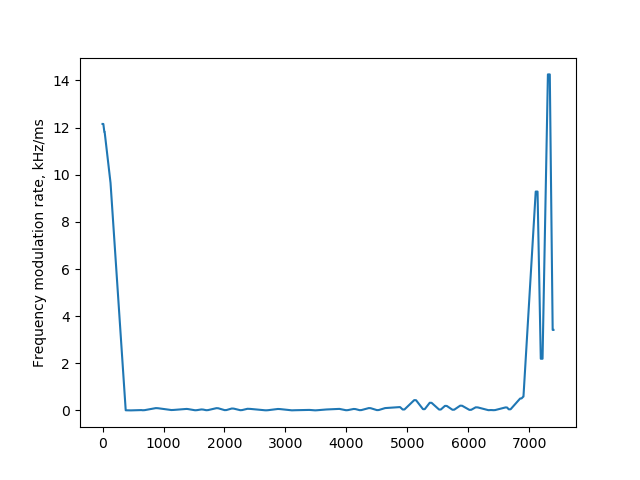

Text(0, 0.5, 'Frequency modulation rate, kHz/ms')

In [41]:
plt.figure()
plt.plot(fm_rate)
plt.ylabel('Frequency modulation rate, kHz/ms')

In [ ]:
print('Notebook last run to the end on', dt.datetime.now())